In [2]:
import torch
import matplotlib.pyplot as plt
import sys
import os
from neuraloperator.neuralop.models import FNO, UNO ,GINO, UQNO , FNOGNO, TFNO, CODANO
from neuraloperator.neuralop import Trainer
from neuraloperator.neuralop.training import AdamW
from neuraloperator.neuralop.data.datasets import load_darcy_flow_small, DarcyDataset
from neuraloperator.neuralop.utils import count_model_params
from neuraloperator.neuralop import LpLoss, H1Loss
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch.nn.functional as F
from Operators.Diff_Op import pdeOperator



In [3]:
d = pdeOperator()
derivation = d.derivative

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


In [4]:
class PreloadedPINNDataset(Dataset):
    """Preloaded Dataset for Physics-Informed Neural Networks"""
    def __init__(self, x, y, p, u_exact=None, operator=None):
        self.samples = []  # Preload all samples here
        for idx in range(len(p)):

            exact = u_exact(x, y, p[idx])
            f = operator(exact, x, y)

            sample = {
                'y': exact.reshape(1, exact.shape[0], exact.shape[1]),
                'x': f.reshape(1, f.shape[0], f.shape[1])
            }
            self.samples.append(sample)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [15]:
d = pdeOperator()
derivation = d.derivative

def creat_coordenates(Nx, Ny , x_min = -1, x_max = 1, y_min = -1, y_max =1 , device = 'cpu'):
    x = torch.linspace(-1, 1, Nx, requires_grad=True , device = device)
    y = torch.linspace(-1, 1, Ny, requires_grad=True , device = device)
    x, y = torch.meshgrid(x, y)
    x = x.unsqueeze(-1)
    y = y.unsqueeze(-1)
    return x, y
def u_exact(x, y, p):
    return torch.exp(p * (-x**2 - y**2))

def operator(u, x, y):
    return derivation(u, x, order=2) + derivation(u, y, order=2)

def create_dataset(Nx, Ny, p_values, u_exact, operator):
    X, Y = creat_coordenates(Nx, Ny)
    dataset = PreloadedPINNDataset(X, Y, p_values, u_exact, operator)
    return dataset

def split_dataset(dataset, train_size = 0.8):
    train_size = int(train_size * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    return train_dataset, test_dataset

def Train_Test_loaders(resolution=16, p_min=5, p_max=15 ,n_samples=20 ,u_exact = u_exact , operator = operator ,train_size = 0.8, batch_size = 32):
    Nx, Ny = resolution , resolution
    p_values = np.linspace(p_min, p_max, n_samples)
    dataset = create_dataset(Nx, Ny, p_values, u_exact, operator)
    train_dataset, test_dataset = split_dataset(dataset, train_size = 0.8)
    train_loader = DataLoader(train_dataset , batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset , batch_size=batch_size, shuffle=False)

    test_loaders = {resolution: test_loader}
    train_loaders = {resolution: train_loader}
    return train_loaders, test_loaders

In [8]:
def load_darcy_flow_copy(n_train,
    n_tests,
    batch_size,
    test_batch_sizes,
    #should replaced by the path to the data
    data_root = "/home/mohammed.khlifi/Solving-PDE-s-using-neural-network/src/neuraloperator/neuralop/data/datasets/data",
    test_resolutions=[16, 32],
    encode_input=False,
    encode_output=True,
    encoding="channel-wise",
    channel_dim=1,):

    dataset = DarcyDataset(root_dir = data_root,
                           n_train=n_train,
                           n_tests=n_tests,
                           batch_size=batch_size,
                           test_batch_sizes=test_batch_sizes,
                           train_resolution=16,
                           test_resolutions=test_resolutions,
                           encode_input=encode_input,
                           encode_output=encode_output,
                           channel_dim=channel_dim,
                           encoding=encoding,
                           download=True)
    
    # return dataloaders for backwards compat
    train_loader = DataLoader(dataset.train_db,
                              batch_size=batch_size,
                              num_workers=0,
                              pin_memory=True,
                              persistent_workers=False,)
    
    test_loaders = {}
    for res,test_bsize in zip(test_resolutions, test_batch_sizes):
        test_loaders[res] = DataLoader(dataset.test_dbs[res],
                                       batch_size=test_bsize,
                                       shuffle=False,
                                       num_workers=0,
                                       pin_memory=True,
                                       persistent_workers=False,)
    
    return train_loader, test_loaders, dataset.data_processor

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

class FVMDerivatives:
    def __init__(self, nx, ny, domain=None):
        # Default domain if none specified
        self.domain = domain or {
            'x': [-1, 1],  # [x_min, x_max]
            'y': [-1, 1],  # [y_min, y_max]
            'boundary_conditions': {
                'left': 0,
                'right': 0,
                'top': 0,
                'bottom': 0
            }
        }
        
        self.nx, self.ny = nx, ny
        self.dx = (self.domain['x'][1] - self.domain['x'][0])/nx
        self.dy = (self.domain['y'][1] - self.domain['y'][0])/ny
        
        # Generate grid
        self.x = torch.linspace(
            self.domain['x'][0] + self.dx/2, 
            self.domain['x'][1] - self.dx/2, 
            nx
        )
        self.y = torch.linspace(
            self.domain['y'][0] + self.dy/2,
            self.domain['y'][1] - self.dy/2,
            ny
        )
        
        # Create mesh
        self.X, self.Y = torch.meshgrid(self.x, self.y, indexing='ij')
        
    
    def laplacian(self, y_pred):
        """Calculate Laplacian using FVM"""
        y_pred = y_pred.squeeze()
        batch_size, nx , ny = y_pred.shape
        dx = 1 / nx
        dy = 1 / ny
        du_dx = (y_pred[:, 2:, 1:-1] - y_pred[:, :-2, 1:-1]) / (2 * dx)
        du_dy = (y_pred[:, 1:-1, 2:] - y_pred[:, 1:-1, :-2]) / (2 * dy)
        #print(du_dx.shape)
        #import sys ; sys.exit()
        # Calculate second derivatives
        d2u_dx2 = (y_pred[:, 2:, 1:-1] - 2*y_pred[:, 1:-1, 1:-1] + y_pred[:, :-2, 1:-1]) / dx**2
        d2u_dy2 = (y_pred[:, 1:-1, 2:] - 2*y_pred[:, 1:-1, 1:-1] + y_pred[:, 1:-1, :-2]) / dy**2

        laplacian = d2u_dx2 + d2u_dy2
        
        return laplacian

    def darcy_flow(self, u , k):
        """Calculate Darcy flow using FVM"""
        
        u = u.squeeze(1)
        k = k.squeeze(1)
        
        # Calculate gradients
        print(u.shape)
        _, nx, ny = u.shape
        dx = 1 / nx
        dy = 1 / ny
        du_dx = (u[:, 2:, 1:-1] - u[:, :-2, 1:-1]) / (2 * dx)
        du_dy = (u[:, 1:-1, 2:] - u[:, 1:-1, :-2]) / (2 * dy)
        
        k = k[: , 1:-1 , 1:-1]
        
        dduddx = (du_dx[:, 2:, 1:-1] - du_dx[:, :-2, 1:-1]) / (2 * dx)
        dduddy = (du_dy[:, 1:-1, 2:] - du_dy[:, 1:-1, :-2]) / (2 * dy)
        
        darcy = -(dduddx + dduddy)

        return darcy


/home/mohammed.khlifi/Solving-PDE-s-using-neural-network/src/neuraloperator/neuralop/data/datasets/pt_dataset.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = tor

Loading test db for resolution 16 with 100 samples 
Loading test db for resolution 32 with 50 samples 
torch.Size([1, 16, 16])


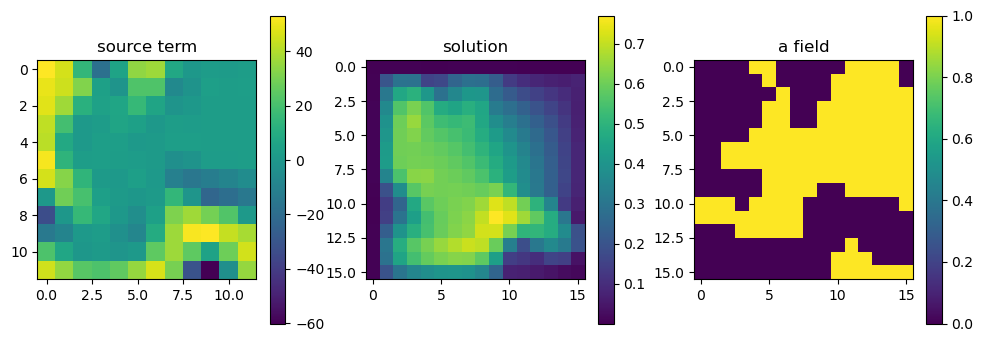

In [5]:
train_loader, test_loaders, _ = load_darcy_flow_small(
            n_train=500, batch_size=32,
            test_resolutions=[16, 32], n_tests=[100, 50],
            test_batch_sizes=[32, 32],
        )


a = train_loader.dataset[6]['x'].unsqueeze(1)
u = train_loader.dataset[6]['y'].unsqueeze(1)

fvm = FVMDerivatives(16, 16)
f = fvm.darcy_flow(u, a)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title('source term')
plt.imshow(f[0].detach().numpy())
plt.colorbar()
plt.subplot(132)
plt.title('solution')
plt.imshow(u.squeeze().detach().numpy())
plt.colorbar()
plt.subplot(133)
plt.title('a field')
plt.imshow(a.squeeze().detach().numpy())
plt.colorbar()
plt.show()




In [10]:
class LossWrapper:
    def __init__(self, loss_fn):
        self.loss_fn = loss_fn
        self.fvm = FVMDerivatives(32, 32)

    def normalize_operator(self, operator):
        """Normalize PDE operator output"""
        return (operator - operator.mean()) / (operator.std() + 1e-8)
    
    def pde_loss(self, pred, **sample):
            
        batch_size = pred.shape[0] 
        #.reshape(batch_size* pred.shape[2]  , pred.shape[3]  )
        pred_f = self.fvm.darcy_flow(pred, sample['x'])

        u_exact = sample.get('y', sample.get('target'))
        f_exact = sample.get('x')
        fdm_f = self.fvm.darcy_flow(u_exact , sample['x'])
        #print(fdm_f.shape , pred_f.shape)
        

        #loss = self.loss_fn(operator[: , : ,1 : -1,1 : -1], target[: , : ,1 : -1,1 : -1])
        loss = self.loss_fn(pred_f, fdm_f.squeeze()) / batch_size
            
        return loss
    
    """def pde_loss(self, pred, **sample):
        batch_size = pred.shape[0]
        print(pred.shape , sample['x'].shape)
        import sys ; sys.exit()"""

        
    def calculate_buondary_conditions(self, u , **sample):
        u_exact = sample['y']
        u = u.squeeze()
        u_exact = u_exact.squeeze()
        
        
        if len(u.shape) == 2:
            u = u.unsqueeze(0)
            u_exact = u_exact.unsqueeze(0)
        
        boundary_conditions = {
            'left': u[:  , :, 0],
            'right': u[: , : , -1],
            'top': u[: , -1 , :],
            'bottom': u[ : , 0 , :]
        }

        exact_boundary_conditions = {
            'left': u_exact[: , :, 0],
            'right': u_exact[: , : , -1],
            'top': u_exact[: , -1 , :],
            'bottom': u_exact[ : , 0 , :]
        }


        loss = 0
        for key in boundary_conditions.keys():
            loss += self.loss_fn(boundary_conditions[key], exact_boundary_conditions[key])

        return loss
    
    def __call__(self, pred, **sample):
        target = sample.get('y', sample.get('target'))
        f_exact = sample.get('x')
        fdm_f = self.fvm.laplacian(target)
        fdm_error = F.mse_loss(fdm_f, f_exact[: , : ,1 : -1,1 : -1].squeeze())    
        pde_loss = self.pde_loss(pred, **sample)

        boundary_loss = self.calculate_buondary_conditions(pred, **sample)

        print(f"pde_loss: {pde_loss}, fdm exact {fdm_error} , data_loss: {boundary_loss}")
        
        return   self.loss_fn(pred, target) #+ boundary_loss +self.loss_fn(pred, target) #* 10**-4 self.loss_fn(pred, target) +self.loss_fn(pred, target)
    
    
class mse_loss:
    def __init__(self):
        self.loss_fn = F.mse_loss
    def __call__(self, pred, **sample):
        target = sample.get('y', sample.get('target'))
        return self.loss_fn(pred, target)


In [9]:
device = "cpu"
model = FNO(n_modes=(16, 16),
            in_channels=1,
            out_channels=1,
            hidden_channels=32,
            projection_channel_ratio=2)

model = model.to(device)
n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 1192801 parameters.


In [12]:
optimizer = AdamW(model.parameters(),
                                lr=0.01,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [16]:
train_loaders , test_loaders = Train_Test_loaders(resolution=32, p_min=5, p_max=6 ,n_samples=3 ,u_exact = u_exact , operator = operator ,train_size = 0.8, batch_size = 32)

train_loader = train_loaders[32]
test_loader = test_loaders[32]

In [24]:
train_loader, test_loaders, _ = load_darcy_flow_copy(
            n_train=500, batch_size=32,
            test_resolutions=[16, 32 , 64 , 128], n_tests=[50, 50 , 50 , 50],
            test_batch_sizes=[32, 32 , 32 , 32],
        )

Loading test db for resolution 16 with 50 samples 
Loading test db for resolution 32 with 50 samples 
Loading test db for resolution 64 with 50 samples 
Loading test db for resolution 128 with 50 samples 


/home/mohammed.khlifi/Solving-PDE-s-using-neural-network/src/neuraloperator/neuralop/data/datasets/pt_dataset.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = tor

In [25]:
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

pino_loss = LossWrapper(F.mse_loss)
train_loss =  h1loss #pino_loss  #  , 'mse_loss' : LossWrapper(F.mse_loss) 
eval_losses={'h1': h1loss, 'l2': l2loss ,'mse_loss' : mse_loss() }

In [26]:
device = "cpu"
trainer = Trainer(model=model, n_epochs= 1,
                  device=device,
                  wandb_log=True,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

In [27]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler= scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 500 samples
Testing on [50, 50, 50, 50] samples         on resolutions [16, 32, 64, 128].
Raw outputs of shape torch.Size([32, 1, 16, 16])
[0] time=2.06, avg_loss=0.6968, train_err=21.7761
Eval: 16_h1=0.5596, 16_l2=0.3614, 16_mse_loss=0.0013, 32_h1=0.7969, 32_l2=0.3851, 32_mse_loss=0.0015, 64_h1=1.1276, 64_l2=0.4018, 64_mse_loss=0.0016, 128_h1=1.5639, 128_l2=0.4110, 128_mse_loss=0.0017


{'train_err': 21.776066184043884,
 'avg_loss': 0.6968341178894043,
 'avg_lasso_loss': None,
 'epoch_train_time': 2.055918335914612,
 '16_h1': tensor(0.5596),
 '16_l2': tensor(0.3614),
 '16_mse_loss': tensor(0.0013),
 '32_h1': tensor(0.7969),
 '32_l2': tensor(0.3851),
 '32_mse_loss': tensor(0.0015),
 '64_h1': tensor(1.1276),
 '64_l2': tensor(0.4018),
 '64_mse_loss': tensor(0.0016),
 '128_h1': tensor(1.5639),
 '128_l2': tensor(0.4110),
 '128_mse_loss': tensor(0.0017)}

torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32])
torch.Size([1, 1, 32, 32])


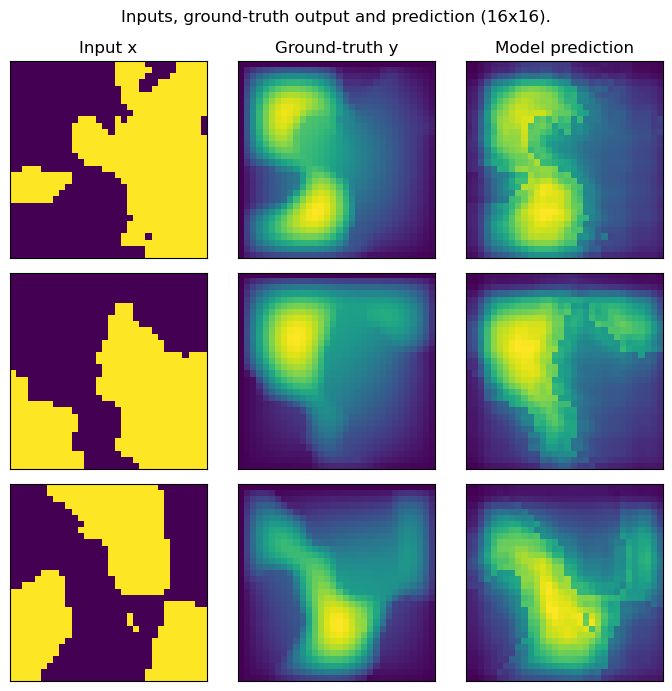

In [28]:
test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    #data = data_processor.preprocess(data, bat
    # ched=False)
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    print(x.unsqueeze(0).shape)
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0].detach().numpy())
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])


    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction (16x16).', y=0.98)
plt.tight_layout()
fig.show()

In [22]:
import pandas as pd
from Models.NO_models import FNO_model, CNN_model, UNO_model, TFNO_model
from Models.PINO import PINO_darcy, PINO_poisson

from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
    

def evluate_learners(models , loader):
    param = {
        'epochs': 20,
        'lr': 0.01,
        'save_version': 0
    }

    kfold = KFold(n_splits=5, shuffle=True)
    results = {model.__name__: [] for model in models}

    AVG_performance = []
    STD_performance = []
    
    train_scores = []
    val_scores = []

    for model_class in models:
        print(f"Training {model_class.__name__}")
        train_fold_scores = []
        val_fold_scores = []
        
        # Perform k-fold cross validation
        for fold, (train_idx, val_idx) in enumerate(kfold.split(loader.dataset)):
            print(f"Fold {fold+1}")
            
            # Create samplers for train/validation split
            train_sampler = SubsetRandomSampler(train_idx)
            val_sampler = SubsetRandomSampler(val_idx)
            
            # Create data loaders
            train_loader_k = DataLoader(
                loader.dataset,
                batch_size=32,
                sampler=train_sampler
            )
            val_loader_k = DataLoader(
                loader.dataset,
                batch_size=32,
                sampler=val_sampler
            )
            
            val_loaders_k = {16: val_loader_k}
            
            # Initialize and train model
            Model = model_class(param = param)
            train_score, val_score = Model.fit(train_loader_k, val_loaders_k)
            
            train_fold_scores.append(train_score)
            val_fold_scores.append(val_score)
        
        # Calculate and display average performance
        avg_performance = np.mean(train_scores)
        std_performance = np.std(train_scores)
        print(f"{model_class.__name__} Average Performance: {avg_performance:.4f} ± {std_performance:.4f}")
        
        AVG_performance.append(avg_performance)
        STD_performance.append(std_performance)
        
        train_scores.append(train_fold_scores)
        val_scores.append(val_fold_scores)
        
    results_df = pd.DataFrame(columns=[model.__name__ for model in models], data=[train_scores, val_scores])
    return train_scores , val_scores

In [6]:
# Setup models and cross-validation
models = [PINO_darcy]

train_losses ,  val_losses = evluate_learners(models , train_loader)

Training PINO_darcy
Fold 1


Epoch 0: Train Loss = 1.2999e-01, Val Loss = 1.4105e-01, H1 Loss = 1.0182e+01 pde_loss = 5.5901e+02
Fold 2
Epoch 0: Train Loss = 1.4412e-01, Val Loss = 2.6968e-01, H1 Loss = 1.3493e+01 pde_loss = 6.8574e+02
Fold 3
Epoch 0: Train Loss = 1.0590e-01, Val Loss = 1.6569e-01, H1 Loss = 9.6975e+00 pde_loss = 3.6156e+02
Fold 4
Epoch 0: Train Loss = 1.3049e-01, Val Loss = 2.4525e-01, H1 Loss = 1.2919e+01 pde_loss = 7.4730e+02
Fold 5
Epoch 0: Train Loss = 1.5285e-01, Val Loss = 2.3800e-01, H1 Loss = 1.5216e+01 pde_loss = 8.2775e+02
PINO_darcy Average Performance: nan ± nan


/home/mohammed.khlifi/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mohammed.khlifi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/mohammed.khlifi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/mohammed.khlifi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/mohammed.khlifi/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Model FNO_model
Average Train Loss: 0.00017324178031860636
Average Validation Loss: 0.02243658103980124
Model CNN_model
Average Train Loss: 0.009351261834112497
Average Validation Loss: 0.042968287412077186
Model UNO_model
Average Train Loss: 0.0007771235131748164
Average Validation Loss: 0.030198169685900212
Model TFNO_model
Average Train Loss: 0.00040956277494282967
Average Validation Loss: 0.013756431336514652
Model PINO_Poisson
Average Train Loss: 0.0002087570888061936
Average Validation Loss: 0.020953241758979856


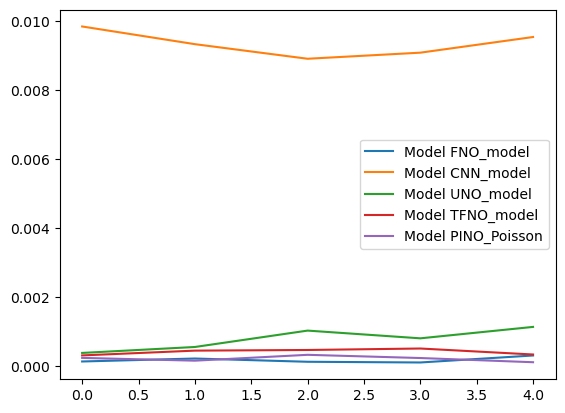

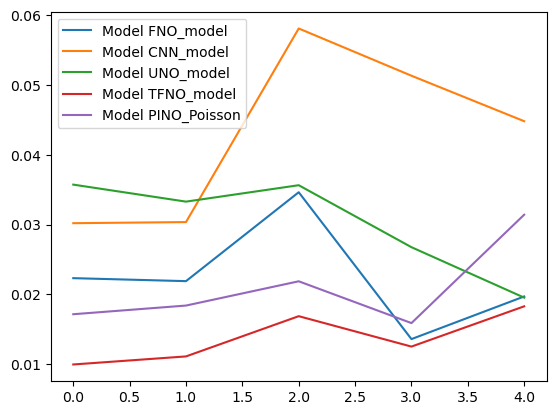

In [37]:
# results using mse loss
train_losses_mse = [[2.4544014964843744e-05, 3.7745661057460194e-05, 3.298824787214891e-06, 4.376311629200175e-05, 0.0003678798183010748], [0.006499164594480624, 0.008276801520528702, 0.008267652422476273, 0.00799703848763154, 0.005864902077099452], [0.000194455036902442, 7.484148899003721e-05, 0.0022788671060250355, 1.7592733246811593e-05, 0.0010891875852114307], [0.0003898504342382344, 0.00026261053930144186, 0.0003030442211848612, 0.0012374773639469193, 0.0002685579507110211], [0.000536935607669875, 2.872774845085447e-05, 0.0006976422513476931, 0.0005352359417324456, 2.508893087976433e-05]]
val_losses_mse = [[0.028769196243956685, 0.021157906157895923, 0.020686541451141238, 0.0204820754006505, 0.04602587781846523], [0.035107871517539024, 0.04590120958164334, 0.04101915843784809, 0.046199260046705604, 0.03399320552125573], [0.04145320178940892, 0.03306087665259838, 0.03662988776341081, 0.030845691915601492, 0.03487462271004915], [0.0159231829456985, 0.018112447578459978, 0.01149660418741405, 0.014335856540128589, 0.02271157270297408], [0.019606260349974036, 0.025849279016256332, 0.01824711775407195, 0.01986421225592494, 0.028785645961761475]]
# results using h1 loss
train_losses = [[0.00012862635552524947, 0.00021474034852312447, 0.00012029292814147014, 9.984601974093284e-05, 0.0003027032496622549], [0.009854591773966184, 0.009341171727730678, 0.00891745094066629, 0.009094296166530022, 0.009548798561669312], [0.00037718950569307286, 0.0005495548293066139, 0.0010253381422864129, 0.0008009915719202792, 0.001132543516667703], [0.0003050401394900221, 0.0004438248333127166, 0.000462474928309138, 0.0005051977014563119, 0.0003312762721459596], [0.00023305146169150248, 0.0001521135580752833, 0.00032238490670211974, 0.000229055447002443, 0.00010718007055961956]]
val_losses = [[0.022331497399136424, 0.02190373558551073, 0.034641710575670004, 0.013598598772659898, 0.019707362866029143], [0.03020696807652712, 0.030366692692041397, 0.05810838844627142, 0.05133808730170131, 0.0448213005438447], [0.03573393216356635, 0.03329742164351046, 0.0356497373431921, 0.02676855819299817, 0.019541199086233974], [0.009962321491912007, 0.011117486632429063, 0.016883503645658493, 0.01252463017590344, 0.018294214736670256], [0.017162655713036656, 0.018404796719551086, 0.021882719360291958, 0.01589266723021865, 0.031423369771800935]]
import matplotlib.pyplot as plt
import numpy as np


names = ['FNO_model', 'CNN_model', 'UNO_model', 'TFNO_model', 'PINO_Poisson']


for i in range(len(train_losses)):
    average_train = np.mean(train_losses[i])
    average_val = np.mean(val_losses[i])
    print(f"Model {names[i]}")
    print(f"Average Train Loss: {average_train}")
    print(f"Average Validation Loss: {average_val}")

for i in range(len(train_losses)):
    plt.plot(train_losses[i], label = f"Model {names[i]}")
plt.legend()
plt.show()


for i in range(len(val_losses)):
    plt.plot(val_losses[i], label = f"Model {names[i]}")
plt.legend()
plt.show()





In [35]:
import pandas as pd
mean_train_losses = [np.mean(losses) for losses in train_losses]
std_train_losses = [np.std(losses) for losses in train_losses]
mean_test_losses = [np.mean(losses) for losses in val_losses]
std_test_losses = [np.std(losses) for losses in val_losses]

mean_train_losses_mse = [np.mean(losses) for losses in train_losses_mse]
std_train_losses_mse = [np.std(losses) for losses in train_losses_mse]
mean_test_losses_mse = [np.mean(losses) for losses in val_losses_mse]
std_test_losses_mse = [np.std(losses) for losses in val_losses_mse]

names = ['FNO_model', 'CNN_model', 'UNO_model', 'TFNO_model', 'PINO_darcy'] 

train_losses_str =[ f"{mean_train_losses[i]:.2e} ± {std_train_losses[i]:.2e}" for i in range(len(mean_train_losses))]
test_losses_str = [f"{mean_test_losses[i]:.2e}" for i in range(len(mean_test_losses))]  
train_losses_mse_str =[ f"{mean_train_losses_mse[i]:.2e} ± {std_train_losses_mse[i]:.2e}" for i in range(len(mean_train_losses_mse))]
test_losses_mse_str = [f"{mean_test_losses_mse[i]:.2e}" for i in range(len(mean_test_losses_mse))]


train_poisson = [[1.068547045216898e-05, 4.782877499565075e-05, 4.6259346693962776e-05, 7.137710080466301e-06, 5.2030783611674757e-05], [1.639752339125759e-05, 1.5178180073386708e-05, 8.713613728635513e-06, 5.193633493642361e-05, 1.0258291704682657e-05], [0.00014757571367833103, 9.131580804933037e-05, 5.274229260976426e-05, 1.4729497744762435e-05, 7.839695687531882e-05], [2.1501075328463532e-05, 2.0468994989641942e-05, 2.0883617518544877e-05, 8.887355496275026e-06, 1.8211006666509395e-05], [3.0384637454972108e-05, 9.964989847806768e-06, 2.6205358854743583e-05, 7.469537033936528e-06, 5.1437713883236334e-05]]
test_poisson = [[0.00014947153613320552, 0.0008490480540785939, 0.00028468042000895366, 0.0001886346253741067, 0.0004468299594009295], [7.594274211442098e-05, 1.9316744328534696e-05, 4.271839725333848e-05, 0.0004345029010437429, 0.0001017548784147948], [6.738822412444279e-05, 4.9884845793712884e-05, 0.0005805062828585505, 7.293891212611925e-05, 0.0008492935885442421], [0.0001562794641358778, 0.00022175267804414034, 0.00021279873180901632, 2.1269197986839572e-05, 0.0001677761938481126], [8.885953138815239e-05, 9.537380356050562e-05, 4.781827738042921e-05, 5.823261631121568e-06, 9.504467561782803e-05]]

mean_train_losses_poisson = [np.mean(losses) for losses in train_poisson]
std_train_losses_poisson = [np.std(losses) for losses in train_poisson]
mean_test_losses_poisson = [np.mean(losses) for losses in test_poisson]
std_test_losses_poisson = [np.std(losses) for losses in test_poisson]

train_losses_poisson_str =[ f"{mean_train_losses_poisson[i]:.2e} ± {std_train_losses_poisson[i]:.2e}" for i in range(len(mean_train_losses_poisson))]
test_losses_poisson_str = [f"{mean_test_losses_poisson[i]:.2e}± {std_test_losses_poisson[i]:.2e}" for i in range(len(mean_test_losses_poisson))]

results_df = pd.DataFrame(columns=names, data=[train_losses_str, test_losses_str , train_losses_poisson_str , test_losses_poisson_str ] , index = ['Train Loss Darcy', 'test Loss Darcy', 'Train Loss Poisson', 'Test Loss Poisson'])

results_df.T

,Train Loss Darcy,test Loss Darcy,Train Loss Poisson,Test Loss Poisson
FNO_model,1.73e-04 ± 7.57e-05,2.24e-02,3.28e-05 ± 1.96e-05,3.84e-04± 2.54e-04
CNN_model,9.35e-03 ± 3.31e-04,4.30e-02,2.05e-05 ± 1.60e-05,1.35e-04± 1.52e-04
UNO_model,7.77e-04 ± 2.83e-04,3.02e-02,7.70e-05 ± 4.39e-05,3.24e-04± 3.30e-04
TFNO_model,4.10e-04 ± 7.77e-05,1.38e-02,1.80e-05 ± 4.69e-06,1.56e-04± 7.19e-05
PINO_darcy,2.09e-04 ± 7.41e-05,2.10e-02,2.51e-05 ± 1.59e-05,6.66e-05± 3.52e-05


In [32]:
train = [[7.766384461168249e-06, 5.829952016256357e-06, 3.3029643986992596e-05, 1.1647521015826593e-05, 1.940756836423437e-05], [2.011495151540051e-05, 3.19832430856574e-05, 1.7083898664319957e-05, 1.1554543827211697e-05, 5.346742530794775e-06], [0.00011002400697179837, 7.606911306841842e-05, 5.8932880316812465e-05, 0.02493494050577283, 3.816022884469324e-05], [8.958600763738408e-06, 1.1877794065640046e-05, 2.4880732970207948e-05, 6.218162582172226e-06, 8.807731404658625e-06], [6.391258523308352e-06, 1.975641100671055e-05, 2.308060012031395e-05, 1.4577061430524433e-05, 0.00013070922280652061]]
test = [[9.055606642505154e-05, 2.1037189071648754e-05, 0.0002552273726905696, 0.00014949088654248044, 3.271061632403871e-05], [6.0425109040807e-05, 3.2630495297780726e-05, 4.902887212665519e-05, 7.474576887034345e-05, 4.376759534352459e-05], [0.0007414258143398911, 0.000796780819655396, 0.00034523084468673915, 0.0726597011089325, 6.806053897889797e-05], [0.00012883191811852157, 0.00031540534109808505, 5.807465822726954e-05, 0.0001185395558422897, 8.887101830623578e-05], [5.281336962070782e-05, 0.00027120432787341997, 0.00011993476437055506, 0.00014810346692684107, 0.0003124726936221123]]


train = [[1.068547045216898e-05, 4.782877499565075e-05, 4.6259346693962776e-05, 7.137710080466301e-06, 5.2030783611674757e-05], [1.639752339125759e-05, 1.5178180073386708e-05, 8.713613728635513e-06, 5.193633493642361e-05, 1.0258291704682657e-05], [0.00014757571367833103, 9.131580804933037e-05, 5.274229260976426e-05, 1.4729497744762435e-05, 7.839695687531882e-05], [2.1501075328463532e-05, 2.0468994989641942e-05, 2.0883617518544877e-05, 8.887355496275026e-06, 1.8211006666509395e-05], [3.0384637454972108e-05, 9.964989847806768e-06, 2.6205358854743583e-05, 7.469537033936528e-06, 5.1437713883236334e-05]]
test = [[0.00014947153613320552, 0.0008490480540785939, 0.00028468042000895366, 0.0001886346253741067, 0.0004468299594009295], [7.594274211442098e-05, 1.9316744328534696e-05, 4.271839725333848e-05, 0.0004345029010437429, 0.0001017548784147948], [6.738822412444279e-05, 4.9884845793712884e-05, 0.0005805062828585505, 7.293891212611925e-05, 0.0008492935885442421], [0.0001562794641358778, 0.00022175267804414034, 0.00021279873180901632, 2.1269197986839572e-05, 0.0001677761938481126], [8.885953138815239e-05, 9.537380356050562e-05, 4.781827738042921e-05, 5.823261631121568e-06, 9.504467561782803e-05]]

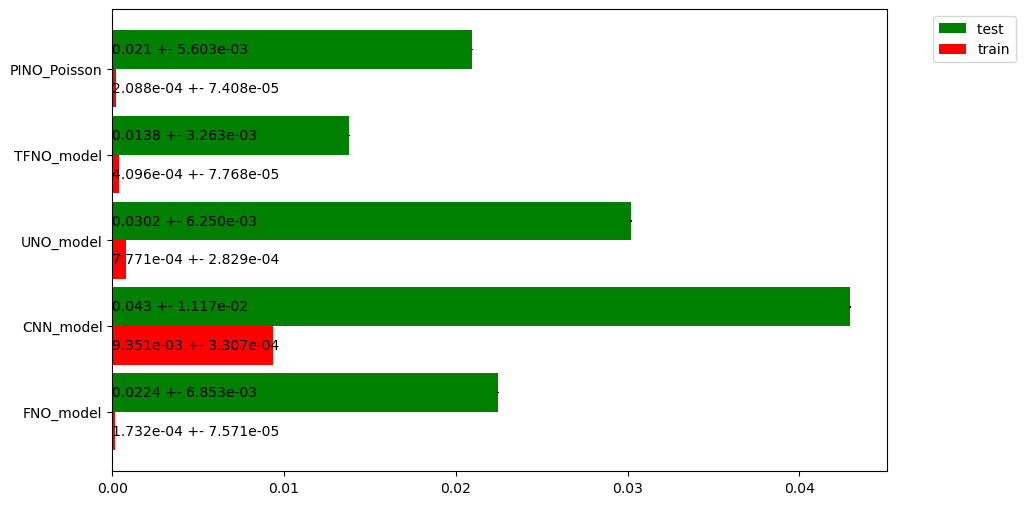

In [47]:
fig, ax = plt.subplots(figsize=(10,6))
width=0.45

train_scores = train_losses
test_scores = val_losses

ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test ')

ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train')

for i, te, tr in zip(np.arange(len(train_scores)), test_scores, train_scores):
    ax.text(0, i, "{:.3} +- {:.3e}".format(np.mean(te), np.std(te)), 
            color=('white' if np.mean(te)>0.1 else 'black'), 
            va='center')
    ax.text(0, i-width, "{:.3e} +- {:.3e}".format(np.mean(tr), np.std(tr)), 
            color=('white' if np.mean(tr)>0.1 else 'black'), 
            va='center')

labels = names

ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=labels)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

In [36]:
param = {
    'epochs': 20,
    'lr': 0.01,
    'save_version': 0
}
model = FNO_model(param = param)
test_loaders_copy = {
    16: test_loaders[16]
}
#train_score, val_score = model.fit(train_loader, test_loaders_copy)

from typing import List, Dict, Any
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np

def evaluate_operator(
    Models: List[Any], 
    train_loader: Any, 
    test_loaders: Dict[int, Any]
) -> Dict[str, Dict[str, float]]:
    """
    Evaluate multiple models on different test datasets.
    
    Args:
        Models: List of model classes to evaluate
        train_loader: DataLoader for training data
        test_loaders: Dictionary of test DataLoaders with batch sizes as keys
    
    Returns:
        Dictionary containing evaluation results for each model and test loader
    """
    param = {
        'epochs': 200,
        'lr': 0.01,
        'save_version': 0
    }
    
    results = {}
    
    # Train models
    trained_models = []
    for model_class in Models:
        model_name = model_class.__name__
        print(f"\nTraining {model_name}")
        
        try:
            model = model_class(param=param)
            # Train on smallest batch size first
            validation_loader = {16: test_loaders[16]}
            train_score, val_score = model.fit(train_loader, validation_loader)
            
            print(f"Train Loss: {train_score:.4f}")
            print(f"Validation Loss: {val_score:.4f}")
            
            trained_models.append((model_name, model))
            
        except Exception as e:
            print(f"Error training {model_name}: {str(e)}")
            continue
    
    # Evaluate on all test loaders
    for batch_size, test_loader in test_loaders.items():
        print(f"\nEvaluating batch size: {batch_size}")
        
        results[f"batch_{batch_size}"] = {}
        
        for model_name, model in trained_models:
            total_loss = 0
            n_batches = 0
            
            try:
                for batch in tqdm(test_loader, desc=f"{model_name}"):
                    x = batch['x']
                    y_true = batch['y']
                    
                    with torch.no_grad():
                        y_pred = model.model(x)
                        loss = F.mse_loss(y_pred.flatten(), y_true.flatten())
                        total_loss += loss.item()
                        n_batches += 1
                
                avg_loss = total_loss / n_batches
                results[f"batch_{batch_size}"][model_name] = avg_loss
                print(f"{model_name} - Average Loss: {avg_loss:.4f}")
                
            except Exception as e:
                print(f"Error evaluating {model_name}: {str(e)}")
                results[f"batch_{batch_size}"][model_name] = float('nan')
    
    return results

# Evaluate models
Models = [UNO_model]
uno_results = evaluate_operator(Models, train_loader, test_loaders)


Training UNO_model
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
fno_skip='linear'
channel_mlp_skip='linear'
Epoch 0: Train Loss = 1.6374e-01, Val Loss = 6.0513e-02, H1 Loss = 1.0310e+01
Epoch 10: Train Loss = 9.3093e-03, Val Loss = 3.1147e-02, H1 Loss = 3.9298e+00
Epoch 20: Train Loss = 8.0957e-03, Val Loss = 1.6967e-02, H1 Loss = 3.6026e+00
Epoch 30: Train Loss = 5.6981e-03, Val Loss = 1.9097e-02, H1 Loss = 3.6743e+00
Epoch 40: Train Loss = 7.9668e-03, Val Loss = 7.7426e-02, H1 Loss = 6.8594e+00
Epoch 50: Train Loss = 4.5667e-03, Val Loss = 1.7024e-02, H1 Loss = 3.1664e+00
Epoch 60: Train Loss = 5.8215e-03, Val Loss = 3.2788e-02, H1 Loss = 3.5759e+00
Epoch 70: Train Loss = 6.4640e-03, Val Loss = 4.5310e-02, H1 Loss = 4.5569e+00
Epoch 80: Train Loss = 5.7861e-03, Val Loss = 2.9809e-02, H1 Loss = 3.1104e+00
Epoch 90: Train Loss = 3.0837e-03, Val Loss = 2.84

UNO_model: 100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


UNO_model - Average Loss: 0.0097

Evaluating batch size: 32


UNO_model: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]


UNO_model - Average Loss: 0.0527

Evaluating batch size: 64


UNO_model: 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]


UNO_model - Average Loss: 0.0416

Evaluating batch size: 128


UNO_model: 100%|██████████| 2/2 [00:14<00:00,  7.12s/it]

UNO_model - Average Loss: 0.0564


In [44]:
all_results = {'batch_16': {'FNO_model': 0.01575629599392414,
  'CNN_model': 0.008832581574097276,
  'TFNO_model': 0.004906846443191171,
  'PINO_darcy': 0.007239366183057427},
  'UNO_model': 0.009731751400977373,
 'batch_32': {'FNO_model': 0.02263804618269205,
  'CNN_model': 0.1129482239484787,
  'TFNO_model': 0.007466681767255068,
  'PINO_darcy': 0.011701645329594612},
  'UNO_model': 0.05266178026795387,
  
 'batch_64': {'FNO_model': 0.02498776465654373,
  'CNN_model': 0.2793899029493332,
  'TFNO_model': 0.009685392025858164,
  'PINO_darcy': 0.014303836971521378},
  'UNO_model': 0.041598642244935036,
 
 'batch_128': {'FNO_model': 0.026484118774533272,
  'CNN_model': 0.3991062343120575,
  'TFNO_model': 0.011119064874947071,
  'PINO_darcy': 0.015813158825039864,
  'UNO_model': 0.0564443226903677},}

def combine_results(uno_results, existing_results):
    final_results = {}
    
    # Initialize structure for each batch size
    batch_sizes = ['batch_16', 'batch_32', 'batch_64', 'batch_128']
    
    for batch in batch_sizes:
        # Get existing models results
        final_results[batch] = existing_results[batch]
        # Add UNO results
        final_results[batch]['UNO_model'] = uno_results[batch]['UNO_model']
        
    return final_results

# Combine results
#all_results = combine_results(uno_results, results)
all_results = {'batch_16': {'FNO_model': 0.01575629599392414,
  'CNN_model': 0.008832581574097276,
  'TFNO_model': 0.004906846443191171,
  'PINO_darcy': 0.007239366183057427,
  'UNO_model': 0.009731751400977373},
 'batch_32': {'FNO_model': 0.02263804618269205,
  'CNN_model': 0.1129482239484787,
  'TFNO_model': 0.007466681767255068,
  'PINO_darcy': 0.011701645329594612,
  'UNO_model': 0.05266178026795387},
 'batch_64': {'FNO_model': 0.02498776465654373,
  'CNN_model': 0.2793899029493332,
  'TFNO_model': 0.009685392025858164,
  'PINO_darcy': 0.014303836971521378,
  'UNO_model': 0.041598642244935036},
 'batch_128': {'FNO_model': 0.026484118774533272,
  'CNN_model': 0.3991062343120575,
  'TFNO_model': 0.011119064874947071,
  'PINO_darcy': 0.015813158825039864,
  'UNO_model': 0.0564443226903677}}


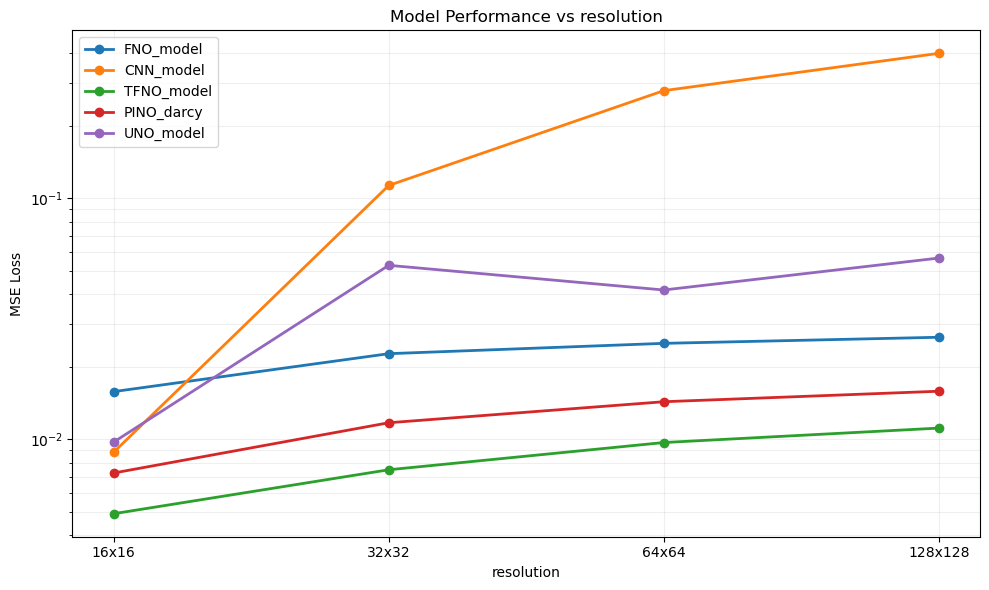

In [43]:
import matplotlib.pyplot as plt
from typing import Dict
import pandas as pd

def plot_results(results: Dict[str, Dict[str, float]], save_path: str = 'model_comparison.png'):
    """Plot model performance across batch sizes."""
    # Prepare data
    plot_data = []
    
    for resolution, model_results in results.items():
        for model_name, loss in model_results.items():
            plot_data.append({
                'resolution': resolution,
                'Model': model_name,
                'Loss': loss
            })

    resolutions= ['16x16' , '32x32' , '64x64' , '128x128']
    
    df = pd.DataFrame(plot_data)
    
    # Create plot
    plt.figure(figsize=(10, 6))
    for model in df['Model'].unique():
        model_data = df[df['Model'] == model]
        plt.plot(resolutions, model_data['Loss'], 
                marker='o', label=model, linewidth=2)
    
    plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.xlabel('resolution')
    plt.ylabel('MSE Loss')
    plt.title('Model Performance vs resolution')
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path)
    #plt.show()

# Add to evaluation code



plot_results(all_results)
#plot_results(results)



In [26]:
for test_loader in test_loaders.values():
    total_loss = 0
    for batch in test_loader:
        x = batch['x']
        y_true = batch['y']
        y_pred = model.model(x)
        
        loss = F.mse_loss(y_pred.flatten(), y_true.flatten())
        total_loss += loss.item()
    print(f"MSE Loss: {total_loss }")

MSE Loss: 0.017767153680324554
MSE Loss: 0.02683967351913452
MSE Loss: 0.03242608159780502
MSE Loss: 0.03571416065096855
